# 

In [1]:
import requests
import pandas as pd
import numpy as np


In [2]:
rpl_assets_url = 'https://api.dune.com/api/v1/query/3351658/results?api_key=fKXF51FhPIqzpGn96BnOcEgw3P9rcJzG'
response = requests.get(rpl_assets_url)

In [3]:
data = response.json()


In [4]:
data_useful = pd.DataFrame(data['result']['rows'])

In [5]:
print(data_useful)

     Cumulative_Net_Eth                          day  net_eth_added
0             32.000000  2021-11-02 00:00:00.000 UTC      32.000000
1             96.000000  2021-11-05 00:00:00.000 UTC      64.000000
2            512.000000  2021-11-09 00:00:00.000 UTC     416.000000
3           1024.000000  2021-11-10 00:00:00.000 UTC     512.000000
4           1040.000000  2021-11-11 00:00:00.000 UTC      16.000000
..                  ...                          ...            ...
787       823074.444249  2024-01-11 00:00:00.000 UTC    -233.978802
788       824861.897424  2024-01-12 00:00:00.000 UTC    1787.453174
789       824452.233577  2024-01-13 00:00:00.000 UTC    -409.663847
790       824361.330257  2024-01-14 00:00:00.000 UTC     -90.903320
791       824382.153055  2024-01-15 00:00:00.000 UTC      20.822798

[792 rows x 3 columns]


In [6]:
data_useful['day'] = pd.to_datetime(data_useful['day'])

In [7]:
data_useful.set_index('day', inplace=True)

In [8]:
import pandas as pd

# Assuming 'df' is your existing DataFrame and it has a DateTimeIndex
# Example: df = pd.DataFrame({'Cumulative_Net_Eth': [32, 96, ...], 'net_eth_added': [32, 64, ...]}, index=pd.to_datetime(['2021-11-02', '2021-11-05', ...]))

# Step 1: Create a date range
start_date = data_useful.index.min()
end_date = data_useful.index.max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Step 2: Reindex your DataFrame
data_useful_reindexed = data_useful.reindex(date_range)

# Step 3: Forward fill missing values
data_useful_filled = data_useful_reindexed.fillna(method='ffill')

# Now 'df_filled' is your DataFrame with missing dates filled in


C:\Users\brandyns pc\AppData\Local\Temp\ipykernel_8952\479055812.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_useful_filled = data_useful_reindexed.fillna(method='ffill')


In [9]:
data_useful_filled

,Cumulative_Net_Eth,net_eth_added
2021-11-02 00:00:00+00:00,32.000000,32.000000
2021-11-03 00:00:00+00:00,32.000000,32.000000
2021-11-04 00:00:00+00:00,32.000000,32.000000
2021-11-05 00:00:00+00:00,96.000000,64.000000
2021-11-06 00:00:00+00:00,96.000000,64.000000
...,...,...
2024-01-11 00:00:00+00:00,823074.444249,-233.978802
2024-01-12 00:00:00+00:00,824861.897424,1787.453174
2024-01-13 00:00:00+00:00,824452.233577,-409.663847
2024-01-14 00:00:00+00:00,824361.330257,-90.903320


In [10]:
assets = data_useful_filled['Cumulative_Net_Eth'].to_frame('net_eth')

assets

,net_eth
2021-11-02 00:00:00+00:00,32.000000
2021-11-03 00:00:00+00:00,32.000000
2021-11-04 00:00:00+00:00,32.000000
2021-11-05 00:00:00+00:00,96.000000
2021-11-06 00:00:00+00:00,96.000000
...,...
2024-01-11 00:00:00+00:00,823074.444249
2024-01-12 00:00:00+00:00,824861.897424
2024-01-13 00:00:00+00:00,824452.233577
2024-01-14 00:00:00+00:00,824361.330257


In [11]:
api_key = 'CG-jTsiV2rsyVSHHULoNSWHU493'


In [12]:
def fetch_rpl_historical_data(api_url, api_key):
    # Use the API key either as a query parameter or in the headers
    params = {'vs_currency': 'usd', 'days': 'max', 'interval': 'daily', 'x_cg_demo_api_key': api_key}
    headers = {'x-cg-demo-api-key': api_key}  # Alternatively, use this header

    response = requests.get(api_url, params=params, headers=headers)

    if response.status_code == 200:
        # Parse the JSON response
        mkr_historical_pricedata = response.json()
        # Extract the 'prices' and 'market_caps' data
        mkr_historical_price = mkr_historical_pricedata['prices']
        mkr_market_cap = pd.DataFrame(mkr_historical_pricedata['market_caps'], columns=['date', 'marketcap'])

        # Convert the 'timestamp' column from UNIX timestamps in milliseconds to datetime objects
        mkr_history = pd.DataFrame(mkr_historical_price, columns=['timestamp', 'price'])
        mkr_history['date'] = pd.to_datetime(mkr_history['timestamp'], unit='ms')
        mkr_history.set_index('date', inplace=True)
        mkr_history.drop(columns='timestamp', inplace=True)
        return mkr_history, mkr_market_cap
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return pd.DataFrame(), pd.DataFrame()

In [13]:
eth_historical_api = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"

eth_history, historical_mk = fetch_rpl_historical_data(eth_historical_api, api_key)

In [14]:
assets.index = assets.index.tz_localize(None)
eth_history['price'].index = eth_history['price'].index.tz_localize(None)

assets_merged = assets.merge(eth_history['price'], left_index=True, right_index=True)


In [16]:
assets_merged = assets.merge(eth_history['price'], left_index=True, right_index=True)

In [17]:
assets_merged['assets_usd'] = assets_merged['net_eth'] * assets_merged['price']

<Axes: >

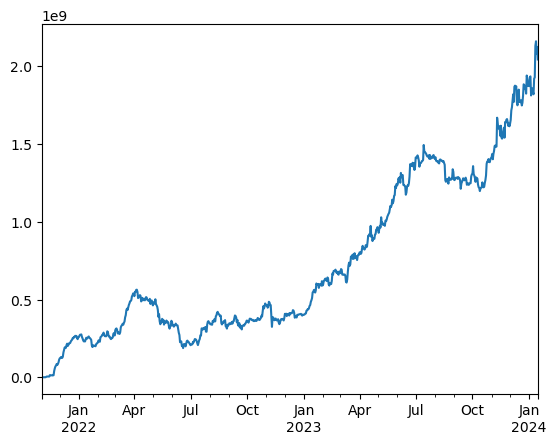

In [18]:
assets_merged['assets_usd'].plot()

In [19]:
assets_merged['assets_usd_formatted'] = assets_merged['assets_usd'].apply(lambda x: f"{x:,.2f}")
assets_merged['assets_usd_formatted']

2021-11-02          138,577.70
2021-11-03          147,090.98
2021-11-04          147,446.38
2021-11-05          436,801.39
2021-11-06          431,501.07
                    ...       
2024-01-11    2,130,749,740.88
2024-01-12    2,159,760,537.96
2024-01-13    2,081,331,060.20
2024-01-14    2,123,492,741.54
2024-01-15    2,042,767,433.60
Name: assets_usd_formatted, Length: 805, dtype: object

In [21]:
rpl_liabilities_url = 'https://api.dune.com/api/v1/query/1282424/results?api_key=fKXF51FhPIqzpGn96BnOcEgw3P9rcJzG'
response = requests.get(rpl_liabilities_url)


data2 = response.json()

data_useful2 = pd.DataFrame(data2['result']['rows'])

data_useful2

,reth_burned,reth_minted,time,total_reth,unique_burners,unique_minters
0,-223.351815,28901.614879,2021-12-15 06:26:57.000 UTC,28678.263064,26,833
1,-223.351815,28901.624802,2021-12-15 07:07:11.000 UTC,28678.272987,26,834
2,-223.351815,28901.634725,2021-12-15 07:07:46.000 UTC,28678.282909,26,835
3,-223.351815,28901.644647,2021-12-15 07:18:50.000 UTC,28678.292832,26,836
4,-223.351815,28924.565480,2021-12-15 08:21:23.000 UTC,28701.213664,26,836
...,...,...,...,...,...,...
38936,-134039.429821,696278.762701,2024-01-06 14:14:35.000 UTC,562239.332880,3801,16925
38937,-134180.579125,697383.257750,2024-01-11 13:37:35.000 UTC,563202.678625,3855,16926
38938,-134395.699931,699270.053867,2024-01-12 18:28:23.000 UTC,564874.353936,3877,16928
38939,-134456.517876,699270.053867,2024-01-13 11:03:35.000 UTC,564813.535991,3885,16928


In [22]:
# Convert 'time' to datetime and set as index
data_useful2['time'] = pd.to_datetime(data_useful2['time'])
data_useful2.set_index('time', inplace=True)

# Now perform the groupby operation



In [23]:
time_series_reth = data_useful2.resample('D').mean()

In [24]:
time_series_reth.fillna(0, inplace=True)

In [25]:
reth_historical_api = "https://api.coingecko.com/api/v3/coins/rocket-pool-eth/market_chart"

reth_history, historical_mk_reth = fetch_rpl_historical_data(reth_historical_api, api_key)

In [26]:
reth_history

,price
date,
2021-11-23 00:00:00,4380.281768
2021-11-24 00:00:00,4380.281768
2021-11-25 00:00:00,4303.942185
2021-11-26 00:00:00,4557.285253
2021-11-27 00:00:00,4075.260067
...,...
2024-01-12 00:00:00,2874.090348
2024-01-13 00:00:00,2767.548027
2024-01-14 00:00:00,2825.230049


In [27]:
time_series_reth.index = time_series_reth.index.tz_localize(None)
reth_history['price'].index = reth_history['price'].index.tz_localize(None)

In [28]:
merged_liabilities = time_series_reth.merge(reth_history['price'], left_index=True, right_index=True)


In [29]:
merged_liabilities['liabilities_usd'] = merged_liabilities['total_reth'] * merged_liabilities['price']
merged_liabilities['formated_liabilities'] = merged_liabilities['liabilities_usd'].apply(lambda x: f"{x:,.2f}")

In [30]:
merged_liabilities

,reth_burned,reth_minted,total_reth,unique_burners,unique_minters,price,liabilities_usd,formated_liabilities
2021-11-23,-32.271292,4063.112297,4030.841005,8.000000,415.909091,4380.281768,1.765622e+07,"17,656,219.36"
2021-11-24,-32.271292,5380.356738,5348.085446,8.000000,436.136364,4380.281768,2.342612e+07,"23,426,121.17"
2021-11-25,-32.271292,6377.332849,6345.061557,8.000000,455.500000,4303.942185,2.730878e+07,"27,308,778.10"
2021-11-26,-32.271292,7277.309185,7245.037893,8.000000,476.285714,4557.285253,3.301770e+07,"33,017,704.35"
2021-11-27,-32.271292,8001.174830,7968.903538,8.000000,499.972222,4075.260067,3.247535e+07,"32,475,354.37"
...,...,...,...,...,...,...,...,...
2024-01-11,-134196.955673,697372.888064,563175.932391,3854.606061,16925.939394,2848.554884,1.604238e+09,"1,604,237,552.99"
2024-01-12,-134362.512016,698222.492708,563859.980693,3868.950820,16927.360656,2874.090348,1.620585e+09,"1,620,584,527.97"
2024-01-13,-134462.034026,699270.053867,564808.019841,3886.565217,16928.000000,2767.548027,1.563133e+09,"1,563,133,321.02"
2024-01-14,-134525.992136,699270.053867,564744.061730,3898.555556,16928.000000,2825.230049,1.595532e+09,"1,595,531,893.38"


In [31]:
liabilities = merged_liabilities['liabilities_usd'].to_frame('liabilities')
assets_df = assets_merged['assets_usd'].to_frame('assets')

balance_sheet = liabilities.merge(assets_df, left_index=True, right_index=True)

In [32]:
balance_sheet['equity'] = balance_sheet['assets'] - balance_sheet['liabilities']

In [33]:
balance_sheet['equity_formatted'] = balance_sheet['equity'].apply(lambda x: f"{x:,.2f}")

In [34]:
balance_sheet

,liabilities,assets,equity,equity_formatted
2021-11-23,1.765622e+07,5.787420e+07,4.021798e+07,"40,217,979.95"
2021-11-24,2.342612e+07,7.003517e+07,4.660905e+07,"46,609,047.83"
2021-11-25,2.730878e+07,7.541534e+07,4.810656e+07,"48,106,560.95"
2021-11-26,3.301770e+07,8.525912e+07,5.224142e+07,"52,241,417.16"
2021-11-27,3.247535e+07,7.934693e+07,4.687158e+07,"46,871,577.38"
...,...,...,...,...
2024-01-11,1.604238e+09,2.130750e+09,5.265122e+08,"526,512,187.89"
2024-01-12,1.620585e+09,2.159761e+09,5.391760e+08,"539,176,009.99"
2024-01-13,1.563133e+09,2.081331e+09,5.181977e+08,"518,197,739.18"
2024-01-14,1.595532e+09,2.123493e+09,5.279608e+08,"527,960,848.16"


In [35]:
historical_mk_reth.index = reth_history.index

In [36]:
historical_mk_reth.index = historical_mk_reth.index.normalize()

In [37]:
historical_mk_reth

,date,marketcap
date,,
2021-11-23,1637625600000,0.000000e+00
2021-11-24,1637712000000,0.000000e+00
2021-11-25,1637798400000,0.000000e+00
2021-11-26,1637884800000,0.000000e+00
2021-11-27,1637971200000,0.000000e+00
...,...,...
2024-01-12,1705017600000,1.617341e+09
2024-01-13,1705104000000,1.559822e+09
2024-01-14,1705190400000,1.597729e+09


In [38]:
historical_mk_reth.index

DatetimeIndex(['2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02',
               ...
               '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-15'],
              dtype='datetime64[ns]', name='date', length=785, freq=None)

In [39]:
liabilities_df = balance_sheet['liabilities'].to_frame('liabilities')

liabilities_df

,liabilities
2021-11-23,1.765622e+07
2021-11-24,2.342612e+07
2021-11-25,2.730878e+07
2021-11-26,3.301770e+07
2021-11-27,3.247535e+07
...,...
2024-01-11,1.604238e+09
2024-01-12,1.620585e+09
2024-01-13,1.563133e+09
2024-01-14,1.595532e+09


In [40]:
enterprise_value = historical_mk_reth.merge(liabilities_df, left_index=True, right_index=True)

In [41]:
enterprise_value['ev_historical'] = enterprise_value['marketcap'] + enterprise_value['liabilities']

In [42]:
enterprise_value['ev_historical']

2021-11-23    1.765622e+07
2021-11-24    2.342612e+07
2021-11-25    2.730878e+07
2021-11-26    3.301770e+07
2021-11-27    3.247535e+07
                  ...     
2024-01-12    3.237926e+09
2024-01-13    3.122956e+09
2024-01-14    3.193261e+09
2024-01-15    3.077831e+09
2024-01-15    3.102976e+09
Name: ev_historical, Length: 785, dtype: float64

In [43]:
rpl_revenue_url = 'https://api.dune.com/api/v1/query/3354037/results?api_key=fKXF51FhPIqzpGn96BnOcEgw3P9rcJzG'
response = requests.get(rpl_revenue_url)


data3 = response.json()

data_useful3 = pd.DataFrame(data3['result']['rows'])

data_useful3



,cumu_node,cumu_node_usd,cumu_rpl,cumu_rpl_usd,day,node_usd,rpl_usd
0,0.078462,3.519903e+02,0.013846,6.211594e+01,2021-11-01 00:00:00.000 UTC,3.519903e+02,62.115937
1,0.941538,4.410738e+03,0.166154,7.783655e+02,2021-11-08 00:00:00.000 UTC,4.058748e+03,716.249571
2,3.373846,1.490747e+04,0.595385,2.630730e+03,2021-11-15 00:00:00.000 UTC,1.049673e+04,1852.364657
3,20.517692,8.716188e+04,3.620769,1.538151e+04,2021-11-22 00:00:00.000 UTC,7.225441e+04,12750.777686
4,45.350769,1.963947e+05,8.003077,3.465789e+04,2021-11-29 00:00:00.000 UTC,1.092328e+05,19276.384634
...,...,...,...,...,...,...,...
111,38814.302740,7.056230e+07,6849.582837,1.245217e+07,2023-12-18 00:00:00.000 UTC,1.913952e+06,337756.291527
112,39679.684471,7.255755e+07,7002.297260,1.280427e+07,2023-12-25 00:00:00.000 UTC,1.995256e+06,352103.924894
113,40551.644712,7.454793e+07,7156.172596,1.315552e+07,2024-01-01 00:00:00.000 UTC,1.990379e+06,351243.342316
114,41430.121346,7.671738e+07,7311.197885,1.353836e+07,2024-01-08 00:00:00.000 UTC,2.169443e+06,382842.874908


In [44]:
data_useful3.set_index('day', inplace=True)
data_useful3.index = pd.to_datetime(data_useful3.index)



In [45]:
rpl_revenue = data_useful3['rpl_usd'].to_frame('rpl_usd')

In [54]:
rpl_revenue

,rpl_usd
day,
2021-11-01 00:00:00+00:00,62.115937
2021-11-08 00:00:00+00:00,716.249571
2021-11-15 00:00:00+00:00,1852.364657
2021-11-22 00:00:00+00:00,12750.777686
2021-11-29 00:00:00+00:00,19276.384634
...,...
2023-12-18 00:00:00+00:00,337756.291527
2023-12-25 00:00:00+00:00,352103.924894
2024-01-01 00:00:00+00:00,351243.342316


In [51]:
start_date1 = rpl_revenue.index.min()
end_date1 = rpl_revenue.index.max()
date_range1 = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# Step 2: Reindex your DataFrame
rpl_revenue_reindexed = rpl_revenue.reindex(date_range)

# Step 3: Fill missing values with 0
rpl_revenue_reindexed['rpl_usd'].fillna(0, inplace=True)


In [59]:
rpl_revenue_reindexed.tail(25)

monthly_revenue = rpl_revenue_reindexed.resample('M').sum()

In [61]:
monthly_revenue.index = monthly_revenue.index.tz_localize(None)

In [63]:
ev_df = enterprise_value.merge(monthly_revenue, left_index=True, right_index=True)

<Axes: >

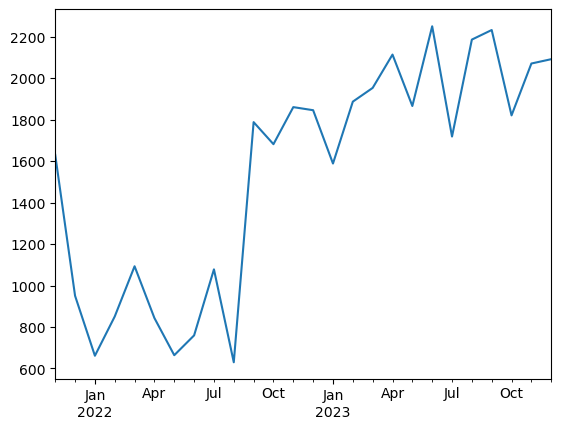

In [66]:
ev_df['ev_to_rev'] = ev_df['ev_historical'] / ev_df['rpl_usd']

ev_df['ev_to_rev'].plot()